# Galaxy fitting

**Parametric & pixelated approaches**

This notebooks performs the fitting of real galaxy images from the COSMOS dataset with two methods:
- Sérsic + shapelets using **lenstronomy** [(Birrer et al. 2018)](https://arxiv.org/abs/1803.09746)
- starlets using **SLITronomy** [(Galan et al. 2020)](https://arxiv.org/abs/2012.02802)

The "Sérsic + shapelets" models are optimized using a Particle Swarm Optimizer (PSO) to optimize non-linear parameters, followed by a weighted least square inversion for linear amplitudes.

The "starlets" models are solved using sparsity and positiviy constraints, within an multi-resolution and iterative filtering approach.

The results are meant to be compared to a VAE source model, using the decoder part to describe surface brightness of galaxies from a vector of latent space variables (typically 64 parameters, meant to reconstruct images with 64x64=4096 pixels).

***

These specific python packages are required to run the notebook:
- `lenstronomy`, from this [**forked repo**](https://github.com/aymgal/lenstronomy/tree/dev-slit-ps) on the `dev-slit-ps` branch
- `slitronomy`, from the [**main repo**](https://github.com/aymgal/slitronomy/tree/master) on the `master` branch

***

__author__: [@aymgal](https://github.com/aymgal)

__contributors__: [@aymgal](https://github.com/aymgal),

__last update__: 19/05/21

## Import modules

In [ ]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

__author__ = 'aymgal'

import matplotlib.pyplot as plt
plt.rc('image', interpolation='none', origin='lower')

import os
import copy
import time
from pprint import pprint
import numpy as np
from matplotlib.colors import LogNorm
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Analysis.image_reconstruction import MultiBandImageReconstruction
from lenstronomy.Plots.model_plot import ModelPlot
#from lenstronomy.Plots import lens_plot, chain_plot
import lenstronomy.Util.util as lenstro_util
from slitronomy.Util.plot_util import nice_colorbar, nice_colorbar_residuals

# seed for noise
np.random.seed(18)

cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='#222222', alpha=1)  # emphasize negative pixels when in log scale

## Choose fitting method and related settings

In [2]:
# general settings
num_images_max = -1
use_original_bkg_noise = False
include_poisson_noise = True
thread_count = 8

# shapelets-related
fit_with_shapelets = False
n_max_choice = 8

# starlers-related
fit_with_starlets = True
starlets_gen2 = False
min_threshold_choice = 5

## Load the dataset

# This is changed

In [3]:
from sklearn.model_selection import train_test_split


#We normalize the data to [0,1]

#Read the images and the features from the google drive
galaxy_images=np.load(Folder+'Data/Radial_cut=0.05/Images_MAD_Filtered.npy')
df=pd.read_csv(Folder+'Data/Radial_cut=0.05/Labels_MAD_Filtered.csv',index_col=0)

#Leave the number of images multiple of the batch_size
Size_of_dataset=len(galaxy_images[:-(len(galaxy_images)%VAE.batch_size)])
Number_of_batches=Size_of_dataset//VAE.batch_size
df=df.iloc[:Size_of_dataset]
df['Noise_sigma']=df['Noise_sigma']/df['max_I']
galaxy_images=galaxy_images[:Size_of_dataset]

#Bring images to a proper tensorial form
gal_dataset_images=np.reshape(VAE.normalize_image(copy.deepcopy(galaxy_images)), 
                              (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1)).astype('float32')
#Separate the features we are eager to predict in the latent space
Features=['max_I','Noise_sigma']

#Extract test dataset
x_train,x_test,y_train,y_test= train_test_split(gal_dataset_images, df[Features].astype('float32'), test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#Extract train and validation datasets
x_train, x_val , y_train, y_val= train_test_split(x_train, y_train, test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#All the sets have number of galaxies which is a multiple of the batch size (32)
#The random_state is fixed so the split is reproducible yet random

Index(['COSMOS_index', 'COSMOS_Bulge_HLR', 'COSMOS_Bulge_I', 'COSMOS_Bulge_n',
       'COSMOS_Bulge_phi', 'COSMOS_Bulge_q', 'COSMOS_Bulge_x0',
       'COSMOS_Bulge_y0', 'COSMOS_Disk_HLR', 'COSMOS_Disk_I', 'COSMOS_Disk_n',
       'COSMOS_Disk_phi', 'COSMOS_Disk_q', 'COSMOS_Disk_x0', 'COSMOS_Disk_y0',
       'COSMOS_Sersic_HLR', 'COSMOS_Sersic_I', 'COSMOS_Sersic_n',
       'COSMOS_Sersic_phi', 'COSMOS_Sersic_q', 'COSMOS_Sersic_x0',
       'COSMOS_Sersic_y0', 'COSMOS_noise', 'COSMOS_use_bulgefit', 'IDENT',
       'Noise_mean', 'Noise_std', 'Original_R_cut', 'Original_x_size',
       'Original_y_size', 'Sersic_HLR', 'Sersic_HLR_err', 'Sersic_I',
       'Sersic_I_err', 'Sersic_n', 'Sersic_n_err', 'Sersic_phi',
       'Sersic_phi_err', 'Sersic_q', 'Sersic_q_err', 'Sersic_r_chi_sq',
       'Sersic_x0', 'Sersic_x0_err', 'Sersic_y0', 'Sersic_y0_err', 'mag_auto',
       'max_I', 'min_I', 'zphot', 'SNR', 'SNR_COSMOS', 'COSMOS_R_cut',
       'NonUniformity', 'R_cut', 'PSNR', 'log_NU'],
      dtype

In [ ]:
Features_number=len(Features)
Features_means=df[Features].mean(axis=0)
Features_stds=df[Features].std(axis=0)

def make_labeled_images(x,labels):
  res=np.zeros((len(x),x.shape[1]+1,x.shape[2],1))
  res[:,:-1,:,:]=x
  res[:,-1,:Features_number,0]=labels
  return res.astype('float32')

x_train_labeled=make_labeled_images(x_train,y_train)
x_test_labeled=make_labeled_images(x_test,y_test)
x_val_labeled=make_labeled_images(x_val,y_val)
galaxies_labeled=make_labeled_images(gal_dataset_images,df[Features])

In [ ]:
#Data to estimate model's quality

COSMOS_indices_to_compare=np.zeros(8,dtype=int)
COSMOS_indices_to_compare=[33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]
images_to_compare_indices=df[np.isin(df.COSMOS_index,COSMOS_indices_to_compare)].index
imgs=np.zeros((32,64,64,1))
imgs[:8] = gal_dataset_images[images_to_compare_indices]
labels_to_compare=np.ones((32,2))
labels_to_compare[:8]=df.iloc[images_to_compare_indices][['max_I','Noise_sigma']]
n_compare = 8

# Here samples are different too

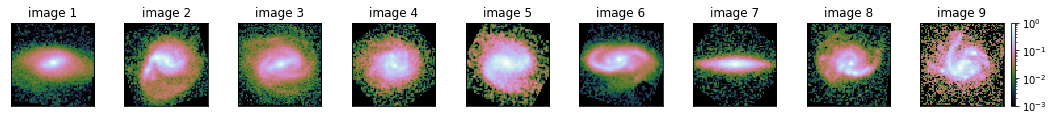

In [4]:
#galaxy_sample = np.load('benchmark_images.npy')  # [0, 1] normalized 64x64 images

#benchmark_indices = [0,34,29,58,160,201,314,425,740]
galaxy_sample = imgs[:8]




#noise_std_sample = np.asarray(df['Noise_std'][benchmark_indices])
#max_I_sample = np.asarray(max_I_n[benchmark_indices])  #list(df['max_I'][benchmark_indices]), there is a small difference between the two

noise_std_sample=np.asarray(labels_to_compare[:8]['Noise_sigma'])
max_I_sample=np.asarray(labels_to_compare[:8]['max_I'])

num_images, num_pix, _, _ = galaxy_sample.shape

if num_images_max is None or num_images_max == -1:
    num_images_max = num_images

fig, axes = plt.subplots(1, num_images, figsize=(18, 3))
for i in range(num_images):
    ax = axes[i]
    ax.set_title(f"image {i+1}")
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    im = ax.imshow(galaxy_sample[i], cmap=cmap_flux, norm=LogNorm(1e-3, 1e0))
    if i == num_images-1:
        nice_colorbar(im)
    else:
        nice_colorbar(im, invisible=True)
plt.show()

## Fill black pixels with background noise

0 -0.002182327 0.01883772570970357 0.0019024786069236105
1 -0.005164297 0.008147276654172982 0.0033207321902571315
2 -2.1969128e-16 0.007859210548533467 0.0036530143559548476
3 -0.0063786027 0.005634817703678858 0.004448473611360746
4 -0.011629168 0.02908974233034762 0.0055855425527422346
5 -0.0014101474 0.01613844810788137 0.001569461865778971
6 -0.0047066365 0.02487192007357324 0.002502080820805527
7 -0.00486962 0.019628369375638905 0.003554919192196145
8 -1.0468982e-15 0.007368166841009518 0.016210392799317557


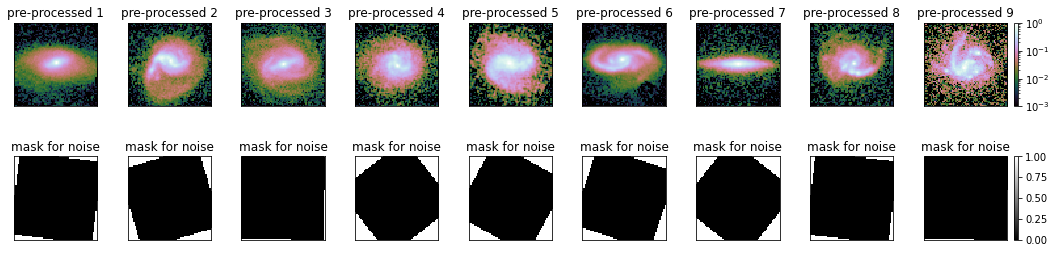

In [5]:
galaxy_sample_pp = []
background_rms_list_o = []
background_rms_list_e = []

factor_bkg_rms = 1 # 0.5

fig, axes = plt.subplots(2, num_images, figsize=(18, 4.5))
for i in range(num_images):
    image_data = np.copy(np.squeeze(galaxy_sample[i]))

    # original bkg noise measurement, rescaled for consistent with the normalized data
    background_rms_orig = noise_std_sample[i] / max_I_sample[i]
    background_rms_list_o.append(background_rms_orig)
    
    # define the region used to estimate background noise
    #roi_xmin = 0
    #roi_xmax = 12
    #roi_ymin = 18
    #roi_ymax = 46
    #roi_bkg_rms = image_data[roi_xmin:roi_xmax, roi_ymin:roi_ymax].flatten()
    #roi2_bkg_rms = image_data[num_pix-roi_xmax:num_pix-roi_xmin+1, roi_ymin:roi_ymax].flatten()
    #roi_bkg_rms = np.append(roi_bkg_rms, roi2_bkg_rms)
    ## estimate background noise using the MAD
    #background_rms_estim = 1.48*np.nanmedian(np.abs(roi_bkg_rms - np.nanmedian(roi_bkg_rms)))
    
    
    # seems more robust: estimation through a wavelet-based estimator
    background_rms_estim = restoration.estimate_sigma(image_data)
    
    
    
    background_rms_list_e.append(background_rms_estim)
    
    print(i, image_data.min(), background_rms_orig, background_rms_estim)
    
    if use_original_bkg_noise:
        bkg_fill = background_rms_orig
    else:
        bkg_fill = background_rms_estim
    bkg_noise = factor_bkg_rms * bkg_fill * np.random.randn(*image_data.shape)
    mask = np.zeros_like(image_data)
    mask[image_data == 0] = 1
    image_data[image_data == 0] = bkg_noise[image_data == 0]
    galaxy_sample_pp.append(image_data)
    
    ax = axes[0, i]
    ax.set_title(f"pre-processed {i+1}")
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    im = ax.imshow(image_data, cmap=cmap_flux, norm=LogNorm(1e-3))
    # markers for the regions used to estimate the background noise
    #ax.axhline(roi_xmin, xmin=roi_ymin/num_pix, xmax=roi_ymax/num_pix, color='red')
    #ax.axvline(roi_ymin, ymin=roi_xmin/num_pix, color='red')
    #ax.axvline(roi_ymax, ymin=roi_xmin/num_pix, color='red')
    if i == num_images-1:
        nice_colorbar(im)
    else:
        nice_colorbar(im, invisible=True)
        
    ax = axes[1, i]
    ax.set_title(f"mask for noise")
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    im = ax.imshow(mask, cmap='gray')
    if i == num_images-1:
        nice_colorbar(im)
    else:
        nice_colorbar(im, invisible=True)
plt.show()
galaxy_sample_pp = np.array(galaxy_sample_pp)

## Setup functions to perform the fits

### Setup data

In [7]:
def setup_data(idx, no_supersampling=False, show_plots=True):
    image_data = galaxy_sample_pp[idx]
    if use_original_bkg_noise:
        background_rms = factor_bkg_rms * background_rms_list_o[idx]
    else:
        background_rms = factor_bkg_rms * background_rms_list_e[idx]
    if include_poisson_noise:
        data_noneg = np.copy(image_data) - background_rms  # remove sky contribution
        data_noneg[data_noneg < 0] = 0  # consider only positive flux areas
        poisson = np.sqrt(max_I_sample[idx] * data_noneg / 2028.)
    else:
        poisson = np.zeros_like(image_data)
    print("poisson mean, poisson median, gaussian", np.mean(poisson), np.median(poisson), background_rms)
    
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, transform_pix2angle, _ \
        = lenstro_util.make_grid_with_coordtransform(num_pix, 1)
    kwargs_data = {
        'image_data': image_data,
        'background_rms': background_rms,
        'noise_map': noise_map,
        'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
        'transform_pix2angle': transform_pix2angle,
    }
    kwargs_psf = {
        'psf_type': 'NONE',
    }
    if no_supersampling is True:
        # for pixel-based (starlets) fitting, no supersampling of the grid
        kwargs_numerics = {'supersampling_factor': 1}
    else:
        # here we super-sample the resolution of some of the pixels where the surface brightness profile has a high gradient 
        supersampled_indexes = np.zeros((num_pix, num_pix), dtype=bool)
        supersampled_indexes[num_pix//2-3:num_pix//2+4, num_pix//2-3:num_pix//2+4] = True
        kwargs_numerics = {
            'supersampling_factor': 3, 
            'compute_mode': 'adaptive',
            'supersampled_indexes': supersampled_indexes,
        }
    kwargs_data_joint = {
        'multi_band_list': [[kwargs_data, kwargs_psf, kwargs_numerics]],
        'multi_band_type': 'single-band',
    }
    if show_plots is True:
        fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
        ax = axes[0]
        ax.set_title("imaging data")
        im = ax.imshow(image_data, cmap=cmap_flux, norm=LogNorm(1e-3))
        nice_colorbar(im)
        ax = axes[1]
        ax.set_title("noise map")
        im = ax.imshow(noise_map, cmap='viridis')
        nice_colorbar(im)
        if no_supersampling is False:
            ax = axes[2]
            ax.set_title("supersampled indexes")
            im = ax.imshow(supersampled_indexes.astype(int), cmap='gray')
            nice_colorbar(im)
        else:
            axes[2].axis('off')
        plt.show()
    return kwargs_data_joint

### Setup shapelets

In [8]:
def setup_fit_shapelets(kwargs_data_joint):
    kwargs_constraints = {
        'solver_type': 'NONE',
    }
    kwargs_likelihood = {
        'image_likelihood': True,
    }
    kwargs_model = {
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SHAPELETS']
    }
    kwargs_lens_light_init = [
        {'R_sersic': 10, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0},
        {'beta': 6, 'center_x': 0, 'center_y': 0},
    ]
    kwargs_lens_light_sigma = [
        {'R_sersic': 1, 'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': 1, 'center_y': 1},
        {'beta': 1, 'center_x': 1, 'center_y': 1},
    ]
    kwargs_lens_light_lower = [
        {'R_sersic': 0.1, 'n_sersic': 0.5, 'e1': -0.8, 'e2': -0.8, 'center_x': -10, 'center_y': -10},
        {'beta': 0.1, 'center_x': -10, 'center_y': -10},
    ]
    kwargs_lens_light_upper = [
        {'R_sersic': 100, 'n_sersic': 8, 'e1': 0.8, 'e2': 0.8, 'center_x': 10, 'center_y': 10},
        {'beta': 100, 'center_x': 10, 'center_y': 10},
    ]
    kwargs_lens_light_fixed = [{}, {'n_max': n_max_choice}]
    kwargs_params = {
        'lens_light_model': [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lens_light_lower, kwargs_lens_light_upper]
    }
    kwargs_constraints = {
        'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]],
    }
    fitSequence = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                                  kwargs_likelihood, kwargs_params)
    fitSequence.param_class.print_setting()
    return fitSequence, kwargs_model

def run_fit_shapelets(fitSequence, fitting_list, kwargs_model, show_plots=True):
    start_time = time.time()
    chain_list = fitSequence.fit_sequence(fitting_list)
    end_time = time.time()
    timing = end_time-start_time
    print("Runtime : {:.3f} s".format(end_time-start_time))
    
    kwargs_result = fitSequence.best_fit()
    print("Optimized parameters:")
    pprint(kwargs_result)
    
    multi_band_list = fitSequence.multi_band_list
    multi_band_type = fitSequence.multi_band_type
    
    # check PSO convergence plot
    if show_plots is True:
        for i in range(len(chain_list)):
            if chain_list[i][0] == 'PSO':
                fig, axes = chain_plot.plot_chain_list(chain_list, i)
                plt.show()
        
        modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, 
                              arrow_size=0.02, cmap_string='cubehelix')
        
        f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
        modelPlot.data_plot(ax=axes[0, 0])
        modelPlot.model_plot(ax=axes[0, 1])
        modelPlot.normalized_residual_plot(ax=axes[0, 2], v_min=-5, v_max=5, cmap=cmap_residuals)
        text = r"$\chi^2={:.2f}$".format(modelPlot._band_plot_list[0]._reduced_x2)
        axes[0, 2].text(0.95, 0.05, text, color='black', fontsize=15, 
                        horizontalalignment='right', verticalalignment='bottom',
                        transform=axes[0, 2].transAxes, bbox={'color': 'white', 'alpha': 0.8})
        modelPlot.decomposition_plot(ax=axes[1, 0], text='Model', lens_light_add=True, unconvolved=True)
        modelPlot.decomposition_plot(ax=axes[1, 1], text='Model convolved', lens_light_add=True)
        modelPlot.subtract_from_data_plot(ax=axes[1, 2], text='Data - Model', lens_light_add=True)
        f.tight_layout()
        plt.show()
        
    # get the model array and corresponding residual maps
    imageRecon = MultiBandImageReconstruction(multi_band_list, kwargs_model, kwargs_result, 
                                              multi_band_type=multi_band_type, verbose=False)
    imageModel, kwargs_model_updt = imageRecon.band_setup()
    model     = imageModel.image(**kwargs_model_updt)
    residuals = imageRecon.model_band_list[0]._norm_residuals
    red_chi2  = imageRecon.model_band_list[0]._reduced_x2
    return kwargs_result, chain_list, model, residuals, red_chi2

### Setup starlets

In [9]:
def setup_fit_starlets(kwargs_data_joint, n_scales=None):
    starlets_model = 'SLIT_STARLETS_GEN2' if starlets_gen2 else 'SLIT_STARLETS'
    kwargs_model = {
        'lens_light_model_list': [starlets_model],
    }
    if n_scales is None:
        n_scales = int(np.log2(num_pix))
    kwargs_lens_light = [{
        'n_scales': n_scales,
        'n_pix_x': num_pix,
        'n_pix_y': num_pix,
    }]
    kwargs_pixelbased = {
        'num_iter_lens': 50,
        'num_iter_weights': 2,
        'min_threshold': min_threshold_choice,
        'threshold_increment_high_freq': 2,
        'sparsity_prior_norm': 1, 'force_positivity': True,
        'verbose': False,
        'show_steps': False,
        'thread_count': thread_count,
    }
    return kwargs_model, kwargs_lens_light, kwargs_pixelbased
    
def run_fit_starlets(kwargs_data_joint, kwargs_model, kwargs_lens_light, kwargs_pixelbased, show_plots=True):
    multi_band_list = kwargs_data_joint['multi_band_list']
    multi_band_type = kwargs_data_joint['multi_band_type']
    kwargs_result = {'kwargs_lens_light': kwargs_lens_light}
    # fit the data using the SLITronomy solver,
    # and get the model array and corresponding residual maps
    imageRecon = MultiBandImageReconstruction(multi_band_list, kwargs_model, kwargs_result, 
                                              multi_band_type=multi_band_type, verbose=False,
                                              kwargs_pixelbased=kwargs_pixelbased)
    # due to the way MultiBandImageReconstruction handles linear inversion in multiband
    # we are forced to use this weird access to the PixelSolver to access the solver history
    pixelSolver = imageRecon._imageModel._imageModel_list[0].PixelSolver
    if show_plots is True:
        fig = pixelSolver.plot_results(log_scale=True, with_history=False,
                                       vmin_res=-5, vmax_res=5, cmap_residuals=cmap_residuals)
        plt.show()
    
    #model     = imageModel.image(**kwargs_model_updt)
    #residuals = imageRecon.model_band_list[0]._norm_residuals
    #red_chi2  = imageRecon.model_band_list[0]._reduced_x2
    model = pixelSolver.image_model()
    residuals = pixelSolver.normalized_residuals_model
    red_chi2 = pixelSolver.best_fit_reduced_chi2
    return kwargs_result, None, model, residuals, red_chi2
    

## Fit the cutouts with _shapelets_

In [10]:
if fit_with_shapelets is True:
    fitting_list = [
        #['SIMPLEX', {'n_iterations': 100, 'method': 'Nelder-Mead'}],
        ['PSO', {'n_iterations': 100, 'n_particles': 100, 'threadCount': thread_count}],
    ]

    model_list_shapelets, residuals_list_shapelets, red_chi2_list_shapelets = [], [], []
    for i in range(num_images_max):
        kwargs_data_joint = setup_data(i, show_plots=(i==0))
        fitSequence, kwargs_model_shapelets = setup_fit_shapelets(kwargs_data_joint)
        kwargs_result_shapelets, chain_list, model, residuals, red_chi2 \
            = run_fit_shapelets(fitSequence, fitting_list, kwargs_model_shapelets)

        model_list_shapelets.append(model)
        residuals_list_shapelets.append(residuals)
        red_chi2_list_shapelets.append(red_chi2)
        

## Fit the cutouts with _starlets_

number of scales: 6
poisson mean, poisson median, gaussian 0.0016106765 0.0011242769 0.0019024786069236105


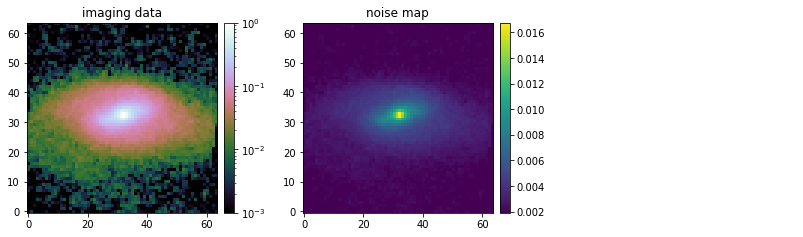

poisson mean, poisson median, gaussian 0.002890028 0.0021666135 0.0033207321902571315
poisson mean, poisson median, gaussian 0.0016652973 0.0013811926 0.0036530143559548476
poisson mean, poisson median, gaussian 0.005158287 0.0036605687 0.004448473611360746
poisson mean, poisson median, gaussian 0.0019476027 0.0014182121 0.0055855425527422346
poisson mean, poisson median, gaussian 0.00086310855 0.0004931366 0.001569461865778971
poisson mean, poisson median, gaussian 0.00047383964 0.00018590881 0.002502080820805527
poisson mean, poisson median, gaussian 0.001179698 0.0007396616 0.003554919192196145
poisson mean, poisson median, gaussian 0.001783052 0.0012021547 0.016210392799317557


In [11]:
n_scales_max = int(np.log2(num_pix))  # maximum allowed by the data
print("number of scales:", n_scales_max)

if fit_with_starlets is True:
    model_list_starlets, residuals_list_starlets, red_chi2_list_starlets = [], [], []
    for i in range(num_images_max):
        kwargs_data_joint = setup_data(i, no_supersampling=True, show_plots=(i==0))
        kwargs_model, kwargs_lens_light_sparsefit, kwargs_pixelbased \
            = setup_fit_starlets(kwargs_data_joint, 
                                 n_scales=n_scales_max)
        kwargs_result_starlets, _, model, residuals, red_chi2 \
            = run_fit_starlets(kwargs_data_joint, kwargs_model, 
                               kwargs_lens_light_sparsefit, kwargs_pixelbased, show_plots=False)

        model_list_starlets.append(model)
        residuals_list_starlets.append(residuals)
        red_chi2_list_starlets.append(red_chi2)

## Summary plot

In [12]:
def plot_fit_summary(model_list, residuals_list, red_chi2_list):
    fig, axes = plt.subplots(3, num_images_max, figsize=(18, 7))
    if num_images_max == 1:
        axes = axes[:, None]
    for i in range(num_images_max):
        ax = axes[0, i]
        ax.set_title(f"data {i+1}")  
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        im = ax.imshow(galaxy_sample_pp[i], cmap=cmap_flux, norm=LogNorm(10**(-2.5), 1e0))
        if i == num_images_max-1:
            nice_colorbar(im, label=r"f${}_{\rm data}$", fontsize=14)
        else:
            nice_colorbar(im, invisible=True)

        ax = axes[1, i]
        ax.set_title(f"model")
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        im = ax.imshow(model_list[i], cmap=cmap_flux, norm=LogNorm(10**(-2.5), 1e0))
        if i == num_images_max-1:
            nice_colorbar(im, label=r"f${}_{\rm model}$", fontsize=14)
        else:
            nice_colorbar(im, invisible=True)

        ax = axes[2, i]
        ax.set_title(f"normalized residuals")
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        im = ax.imshow(residuals_list[i], cmap=cmap_residuals, vmin=-5, vmax=5)
        text = r"$\chi^2={:.2f}$".format(red_chi2_list[i])
        ax.text(0.05, 0.05, text, color='black', fontsize=12, 
                horizontalalignment='left', verticalalignment='bottom',
                transform=ax.transAxes, bbox={'color': 'white', 'alpha': 0})
        if i == num_images_max-1:
            nice_colorbar(im, label=r"(f${}_{\rm model}$ - f${}_{\rm data}$)/$\sigma$", fontsize=14)
        else:
            nice_colorbar(im, invisible=True)
    fig.tight_layout()
    return fig

STARLETS


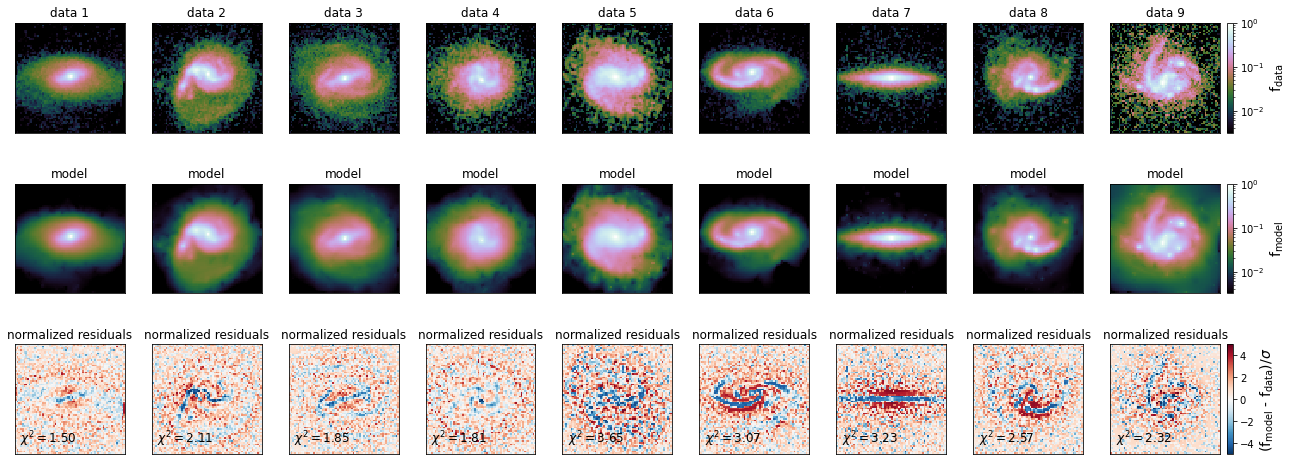

In [13]:
if fit_with_shapelets is True:
    print("SHAPELETS")
    fig = plot_fit_summary(model_list_shapelets, residuals_list_shapelets, red_chi2_list_shapelets)
    plt.show()
    #fig.savefig("fit_shapelets_nmax{}.png".format(n_max_choice), bbox_inches='tight')
    
if fit_with_starlets is True:
    print("STARLETS")
    fig = plot_fit_summary(model_list_starlets, residuals_list_starlets, red_chi2_list_starlets)
    plt.show()
    #fig.savefig("fit_starlets_lambda{}_gen2{}.png".format(min_threshold_choice, starlets_gen2), bbox_inches='tight')